In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import sys
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


# remove warnings
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

# 1. Loading Dataset

In [2]:
# Loading the data
new_data = pd.read_csv("/kaggle/input/seperated-data/India_Lucknow.csv")

# print the shape
print(new_data.shape)

#runs the first 5 rows
new_data.head()

(2297, 12)


,Date,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
0,2014-12-29,18.9,0.8,NaN,177.0,NaN,3.3,NaN,NaN,NaN,NaN,India_Lucknow
1,2014-12-30,18.5,0.7,NaN,258.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
2,2014-12-31,0.2,2.3,NaN,58.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
3,2015-01-01,18.5,1.0,NaN,188.0,NaN,3.5,NaN,NaN,NaN,NaN,India_Lucknow
4,2015-01-02,18.5,1.2,NaN,140.0,NaN,3.6,NaN,NaN,NaN,NaN,India_Lucknow


In [3]:
# Find the minimum and maximum dates
min_date = new_data['Date'].min()
max_date = new_data['Date'].max()

print('Minimum date:', min_date)
print('Maximum date:', max_date)

Minimum date: 2014-12-29
Maximum date: 2023-10-01


In [4]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2297 non-null   object 
 1   co            2294 non-null   float64
 2   no2           2297 non-null   float64
 3   o3            2243 non-null   float64
 4   pm10          1151 non-null   float64
 5   pm25          2231 non-null   float64
 6   so2           2291 non-null   float64
 7   humidity      1672 non-null   float64
 8   pressure      1672 non-null   float64
 9   temperature   1671 non-null   float64
 10  wind-speed    1603 non-null   float64
 11  Country_City  2297 non-null   object 
dtypes: float64(10), object(2)
memory usage: 215.5+ KB


In [5]:
new_data.describe()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed
count,2294.000000,2297.000000,2243.000000,1151.000000,2231.000000,2291.000000,1672.000000,1672.000000,1671.000000,1603.000000
mean,9.589974,13.868829,13.235533,96.384883,152.608696,3.795199,63.791567,939.753170,26.178276,0.550655
std,3.128279,7.460949,7.828471,56.502162,56.077578,1.413211,21.900501,185.198185,6.204938,0.291523
min,0.100000,0.400000,1.600000,13.000000,29.000000,0.900000,0.000000,0.000000,7.000000,0.000000
25%,7.800000,7.900000,8.000000,56.000000,109.000000,2.800000,48.875000,991.375000,21.900000,0.400000
50%,9.300000,12.700000,11.400000,86.000000,161.000000,3.700000,67.000000,1002.000000,28.000000,0.500000
75%,10.600000,18.200000,16.300000,122.000000,181.000000,4.500000,81.200000,1009.700000,31.000000,0.600000
max,42.000000,48.100000,62.600000,591.000000,420.000000,9.900000,97.500000,1023.000000,36.700000,4.100000


In [6]:
# Investigate all the elements whithin each Feature

for column in new_data:
    # Handle numerical and string columns differently
    if new_data[column].dtype == 'object':  # Check if column is of object type
        unique_vals = new_data[column].unique()  # pandas unique for strings
    else:
        unique_vals = np.unique(new_data[column])  # numpy unique for numerical types

    nr_values = len(unique_vals)
    if nr_values < 14:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :2296
The number of values for feature co :177
The number of values for feature no2 :332
The number of values for feature o3 :303
The number of values for feature pm10 :215
The number of values for feature pm25 :278
The number of values for feature so2 :82
The number of values for feature humidity :589
The number of values for feature pressure :427
The number of values for feature temperature :208
The number of values for feature wind-speed :25
The number of values for feature Country_City :1 -- ['India_Lucknow']


In [7]:
new_data.isna().sum()

Date               0
co                 3
no2                0
o3                54
pm10            1146
pm25              66
so2                6
humidity         625
pressure         625
temperature      626
wind-speed       694
Country_City       0
dtype: int64

# 1.2 - Function -- Preprocessing

In [8]:
print(os.listdir('/kaggle/usr/lib/function-v'))

['function_v.py', '__results__.html', '__notebook__.ipynb', '__output__.json', 'custom.css']


In [9]:
sys.path.append("/kaggle/usr/lib/function_v")  # Add directory to the path

import function_v as fn

# Datetime index 

In [10]:
# Use the functions
new_data1 = fn.prepare_datetime_index(new_data, date_column='Date')
new_data1.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
Date,,,,,,,,,,,
2014-12-29,18.9,0.8,NaN,177.0,NaN,3.3,NaN,NaN,NaN,NaN,India_Lucknow
2014-12-30,18.5,0.7,NaN,258.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
2014-12-31,0.2,2.3,NaN,58.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
2015-01-01,18.5,1.0,NaN,188.0,NaN,3.5,NaN,NaN,NaN,NaN,India_Lucknow
2015-01-02,18.5,1.2,NaN,140.0,NaN,3.6,NaN,NaN,NaN,NaN,India_Lucknow


In [11]:
new_data1.columns

Index(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'],
      dtype='object')

In [12]:
# Drop collumns which have large quantity of missing value and of no use
new_data2 = new_data1.drop(['pm10','humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'], axis= 1)

In [13]:
new_data2.isna().sum()

co       3
no2      0
o3      54
pm25    66
so2      6
dtype: int64

# Imputing 

In [14]:
new_data2.columns

Index(['co', 'no2', 'o3', 'pm25', 'so2'], dtype='object')

In [15]:
# Fill the missing value 

imputer = SimpleImputer(strategy="mean")

# Select the columns
columns_to_impute = ['co', 'o3', 'pm25', 'so2']

new_data2[columns_to_impute] = imputer.fit_transform(new_data2[columns_to_impute])

In [16]:
new_data2.isna().sum()

co      0
no2     0
o3      0
pm25    0
so2     0
dtype: int64

# Missing Dates

In [17]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data2.index.min(), end=new_data2.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data2.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2015-01-03', '2015-01-04', '2015-01-08', '2015-01-10',
               '2015-01-17', '2015-01-18', '2015-01-20', '2015-01-21',
               '2015-01-22', '2015-02-07',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-22', '2022-10-23', '2023-04-01', '2023-04-02',
               '2023-05-20', '2023-05-21'],
              dtype='datetime64[ns]', length=903, freq=None)


In [18]:
new_data3 = fn.impute_missing_dates(new_data2)

In [19]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data3.index.min(), end=new_data3.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data3.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [20]:
duplicates = new_data3.index[new_data3.index.duplicated()]
print(f"Duplicate indexes: {duplicates}")

Duplicate indexes: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


# AQI Count

In [21]:
new_data4 = fn.calculate_aqi(new_data3)

In [22]:
new_data4.head()

,co,no2,o3,pm25,so2,AQI
2014-12-29,18.9,0.8,13.238046,152.641704,3.3,153.0
2014-12-30,18.5,0.7,13.238046,152.641704,3.2,153.0
2014-12-31,0.2,2.3,13.238046,152.641704,3.2,153.0
2015-01-01,18.5,1.0,13.238046,152.641704,3.5,153.0
2015-01-02,18.5,1.2,13.238046,152.641704,3.6,153.0


# 1.3 - Plot & Heatmap

<Axes: >

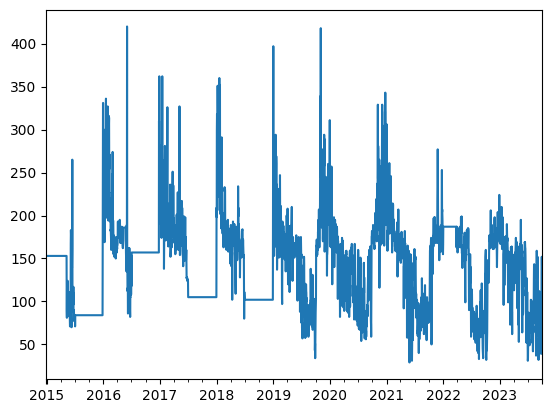

In [23]:
norm_aqi = new_data4['AQI']
norm_aqi.plot()

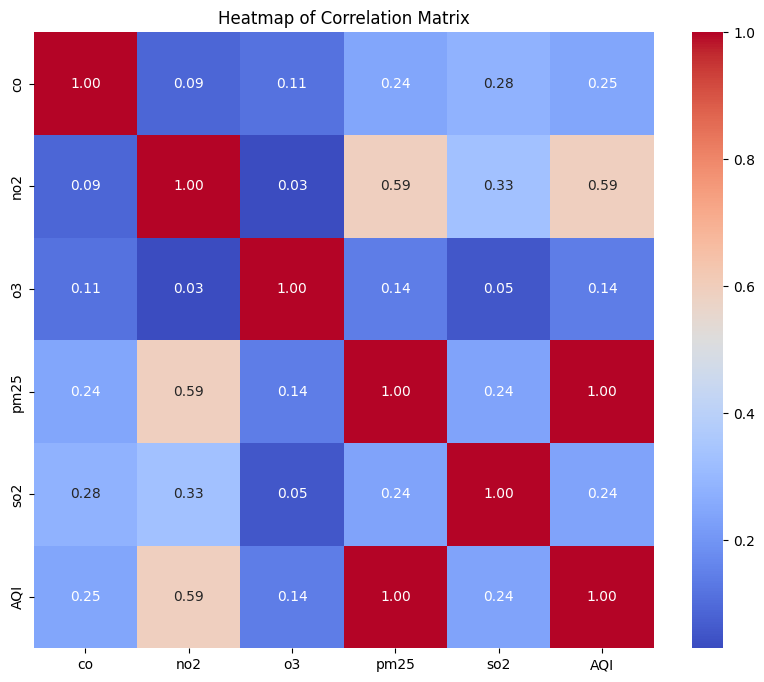

In [24]:
# Calculate the correlation matrix for numeric columns
corr = new_data4.corr(numeric_only=True)

# Create a heatmap using the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlation Matrix")
#file_name = "correlation_matrix.png"
#path = "/kaggle/working/data-after-combine"
#plt.savefig(path,file_name)
plt.show()

# 2. Machine Learning (without scaling)

# 2.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [25]:
new_data4.columns

Index(['co', 'no2', 'o3', 'pm25', 'so2', 'AQI'], dtype='object')

In [26]:
data = new_data4.copy()

In [27]:
data.head()

,co,no2,o3,pm25,so2,AQI
2014-12-29,18.9,0.8,13.238046,152.641704,3.3,153.0
2014-12-30,18.5,0.7,13.238046,152.641704,3.2,153.0
2014-12-31,0.2,2.3,13.238046,152.641704,3.2,153.0
2015-01-01,18.5,1.0,13.238046,152.641704,3.5,153.0
2015-01-02,18.5,1.2,13.238046,152.641704,3.6,153.0


In [28]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['co', 'no2', 'o3', 'pm25', 'so2', 'AQI'], dtype='object')
Index([], dtype='object')


In [30]:
X = data[['co', 'no2', 'o3', 'pm25', 'so2']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2559, 5) (2559,) (640, 5) (640,)


In [31]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['co', 'no2', 'o3', 'pm25', 'so2'])
    ])
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 2.2. ML Model

In [32]:
def compare_and_save_models(X_train, X_test, y_train, y_test, preprocessor, metric='mse', save_dir='models'):
    
    
    # Initialize models
    models = {
        'knn': KNeighborsRegressor(n_neighbors=2),
        'random_forest': RandomForestRegressor(),
        'xgboost': XGBRegressor(objective='reg:squarederror'),
        'svr' : SVR(kernel='linear'),
        'neural_network': MLPRegressor(hidden_layer_sizes=(8,), activation='relu', 
                                     solver='adam', max_iter=2000, 
                                     learning_rate_init=0.0005)
    }
    
    # Dictionary to store results
    results = {}
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Train and evaluate each model
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('regressor', model)])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae_train': mean_absolute_error(y_train, y_pred_train),
            'mae_test': mean_absolute_error(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test)
        }
        
        results[name] = {
            'pipeline': pipeline,
            'metrics': metrics
        }
    
    # Determine best model based on specified metric
    metric_map = {
        'r2': 'r2_test',
        'rmse': 'rmse_test',
        'mae': 'mae_test',
        'mse': 'mse_test'
    }
    
    comparison_metric = metric_map[metric]
    
    if metric == 'r2':  # Only R² should use max, all others should use min
        best_model = max(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    else:  # For MSE, RMSE, MAE - lower is better
        best_model = min(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    
    # Save the best model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, 
                             f'best_model_{best_model[0]}_{timestamp}.joblib')
    joblib.dump(best_model[1]['pipeline'], model_path)
    
    # Prepare return dictionary
    return_dict = {
        'best_model': best_model[0],
        'best_model_path': model_path,
        'model_performances': {name: results[name]['metrics'] 
                             for name in results.keys()}
    }
    
    return return_dict

In [33]:
# Get the results first
results = compare_and_save_models(
    X_train, X_test, y_train, y_test,
    preprocessor,
    metric='mse',
    save_dir='models'
)

In [34]:
# Print detailed results for all models
print("\nDetailed Model Performance Summary:")
print("-" * 50)

for model_name, performance in results['model_performances'].items():
    print(f"\n{model_name.upper()} Results:")
    print(f"R² score (train): {performance['r2_train']:.4f}")
    print(f"R² score (test): {performance['r2_test']:.4f}")
    print(f"RMSE (train): {performance['rmse_train']:.4f}")
    print(f"RMSE (test): {performance['rmse_test']:.4f}")
    print(f"MAE (train): {performance['mae_train']:.4f}")
    print(f"MAE (test): {performance['mae_test']:.4f}")
    print(f"MSE (train): {performance['mse_train']:.4f}")
    print(f"MSE (test): {performance['mse_test']:.4f}")

print("\n" + "=" * 50)
print(f"Best Model: {results['best_model']}")
print(f"Model saved at: {results['best_model_path']}")


Detailed Model Performance Summary:
--------------------------------------------------

KNN Results:
R² score (train): 0.9998
R² score (test): 0.9993
RMSE (train): 0.7895
RMSE (test): 1.3887
MAE (train): 0.4574
MAE (test): 0.7852
MSE (train): 0.6234
MSE (test): 1.9285

RANDOM_FOREST Results:
R² score (train): 0.9999
R² score (test): 0.9999
RMSE (train): 0.4244
RMSE (test): 0.5322
MAE (train): 0.0381
MAE (test): 0.0659
MSE (train): 0.1801
MSE (test): 0.2833

XGBOOST Results:
R² score (train): 1.0000
R² score (test): 0.9975
RMSE (train): 0.1145
RMSE (test): 2.5887
MAE (train): 0.0632
MAE (test): 0.4062
MSE (train): 0.0131
MSE (test): 6.7015

SVR Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0797
RMSE (test): 0.0850
MAE (train): 0.0629
MAE (test): 0.0648
MSE (train): 0.0063
MSE (test): 0.0072

NEURAL_NETWORK Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.1250
RMSE (test): 0.1139
MAE (train): 0.0673
MAE (test): 0.0682
MSE (train): 0.0

# 3. Machine Learning (with scaling)

# 3.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [ ]:
new_data4.columns

In [ ]:
data = new_data4.copy()

In [ ]:
data.head()

In [ ]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

In [ ]:
X = data[['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[ 
            ('scaler', StandardScaler())
        ]), ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2'])  
    ])
    
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 3.2. ML Model

In [ ]:
def compare_and_save_models(X_train, X_test, y_train, y_test, preprocessor, metric='mse', save_dir='models'):
    
    
    # Initialize models
    models = {
        'knn': KNeighborsRegressor(n_neighbors=2),
        'random_forest': RandomForestRegressor(),
        'xgboost': XGBRegressor(objective='reg:squarederror'),
        'svr' : SVR(kernel='linear'),
        'neural_network': MLPRegressor(hidden_layer_sizes=(8,), activation='relu', 
                                     solver='adam', max_iter=2000, 
                                     learning_rate_init=0.0005)
    }
    
    # Dictionary to store results
    results = {}
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Train and evaluate each model
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('regressor', model)])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae_train': mean_absolute_error(y_train, y_pred_train),
            'mae_test': mean_absolute_error(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test)
        }
        
        results[name] = {
            'pipeline': pipeline,
            'metrics': metrics
        }
    
    # Determine best model based on specified metric
    metric_map = {
        'r2': 'r2_test',
        'rmse': 'rmse_test',
        'mae': 'mae_test',
        'mse': 'mse_test'
    }
    
    comparison_metric = metric_map[metric]
    
    if metric == 'r2':  # Only R² should use max, all others should use min
        best_model = max(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    else:  # For MSE, RMSE, MAE - lower is better
        best_model = min(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    
    # Save the best model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, 
                             f'best_model_{best_model[0]}_{timestamp}.joblib')
    joblib.dump(best_model[1]['pipeline'], model_path)
    
    # Prepare return dictionary
    return_dict = {
        'best_model': best_model[0],
        'best_model_path': model_path,
        'model_performances': {name: results[name]['metrics'] 
                             for name in results.keys()}
    }
    
    return return_dict

In [ ]:
# Get the results first
results = compare_and_save_models(
    X_train, X_test, y_train, y_test,
    preprocessor,
    metric='mse',
    save_dir='models'
)

In [ ]:
# Print detailed results for all models
print("\nDetailed Model Performance Summary:")
print("-" * 50)

for model_name, performance in results['model_performances'].items():
    print(f"\n{model_name.upper()} Results:")
    print(f"R² score (train): {performance['r2_train']:.4f}")
    print(f"R² score (test): {performance['r2_test']:.4f}")
    print(f"RMSE (train): {performance['rmse_train']:.4f}")
    print(f"RMSE (test): {performance['rmse_test']:.4f}")
    print(f"MAE (train): {performance['mae_train']:.4f}")
    print(f"MAE (test): {performance['mae_test']:.4f}")
    print(f"MSE (train): {performance['mse_train']:.4f}")
    print(f"MSE (test): {performance['mse_test']:.4f}")

print("\n" + "=" * 50)
print(f"Best Model: {results['best_model']}")
print(f"Model saved at: {results['best_model_path']}")

# 4 - Deep Learning Model(Without Scaling)

# 4.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [35]:
aqi_normal = new_data4.copy()

In [36]:
def new_data_to_X_y(new_data, window_size, train_pct, val_pct, test_pct):
    
    new_data_as_np = new_data.to_numpy()
    
    # Split features and target
    features = new_data_as_np[:, :-1]  # All columns except the last one
    target = new_data_as_np[:, -1]     # Only the AQI column
    
    # Split data based on percentages
    total_len = len(features)
    train_end = int(train_pct * total_len)
    val_end = train_end + int(val_pct * total_len)
    
    # Prepare train, val, and test splits for both features and target
    train_features = features[:train_end]
    train_target = target[:train_end]
    
    val_features = features[train_end:val_end]
    val_target = target[train_end:val_end]
    
    test_features = features[val_end:]
    test_target = target[val_end:]
    
    # Helper function to create X and y
    def create_X_y(feature_data, target_data):
        X, y = [], []
        for i in range(len(feature_data) - window_size):
            # Create sequence of all features
            sequence = feature_data[i:i + window_size]
            X.append(sequence)
            # Get the target AQI value
            y.append(target_data[i + window_size])
        return np.array(X), np.array(y)
    
    
    X_train, y_train = create_X_y(train_features, train_target)
    X_val, y_val = create_X_y(val_features, val_target)
    X_test, y_test = create_X_y(test_features, test_target)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [37]:
WINDOW_SIZE = 6
NUM_FEATURES = 5
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = new_data_to_X_y(
    aqi_normal, WINDOW_SIZE, train_pct, val_pct, test_pct
)

In [38]:
# shapes
print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

Train shapes: (2553, 6, 5) (2553,)
Validation shapes: (313, 6, 5) (313,)
Test shapes: (315, 6, 5) (315,)


#  4.2. DL Model

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

Bi-LSTM

In [40]:
lstm_model = Sequential()
lstm_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
lstm_model.add(BatchNormalization())
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(1, activation='linear'))

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 6, 128)              │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,829 (311.83 KB)

 Trainable params: 79,755 (311.54 KB)

 Non-trainable params: 74 (296.00 B)

In [41]:
cp1 = ModelCheckpoint('/kaggle/working/lstm_model1.keras', save_best_only=True)

lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [42]:
lstm_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp1])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 23925.8984 - mean_absolute_error: 146.0809 - val_loss: 21235.4512 - val_mean_absolute_error: 137.2086
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23126.8555 - mean_absolute_error: 143.4825 - val_loss: 20502.9551 - val_mean_absolute_error: 135.0123
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 22960.4629 - mean_absolute_error: 142.9741 - val_loss: 19164.6816 - val_mean_absolute_error: 130.8527
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21421.2812 - mean_absolute_error: 137.8753 - val_loss: 17319.0703 - val_mean_absolute_error: 124.7227
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19604.8125 - mean_absolute_error: 132.1979 - val_loss: 14736.3838 - val_mean_absolute_error: 114.9556
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17947.9609 - mean_absolute_error: 125.8002 - val_loss: 10836.9199 - val_mean_absolute_error: 97.7532
Epoch 7/100
80/80 ━━━━━━━━━━━

In [43]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/lstm_model1.keras')

In [44]:
# Evaluate the model on the train data
train_result = model1.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 13.2971
Mean Squared Error (MSE): 499.3897
Root Mean Squared Error (RMSE): 22.3470
R-squared (Accuracy): 0.8211


In [45]:
# Evaluate the model on the validation data
val_result = model1.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 9.7215
Mean Squared Error (MSE): 243.1909
Root Mean Squared Error (RMSE): 15.5946
R-squared (Accuracy): 0.9069


In [46]:
# Evaluate the model on the test data
test_result = model1.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 16.8291
Mean Squared Error (MSE): 535.8936
Root Mean Squared Error (RMSE): 23.1494
R-squared (Accuracy): 0.7315


In [47]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,148.476013,153.0
1,148.613922,153.0
2,147.845917,153.0
3,145.097733,153.0
4,145.550507,153.0
...,...,...
2548,199.845016,207.0
2549,200.227234,198.0
2550,197.505798,193.0
2551,194.552979,163.0


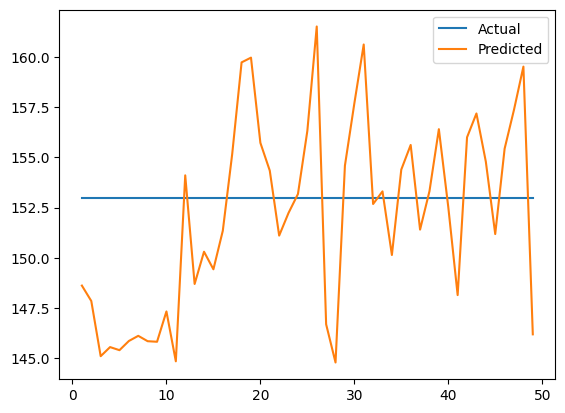

In [48]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [49]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,186.400070,187.0
1,186.497894,187.0
2,187.206436,187.0
3,187.206436,187.0
4,187.206436,187.0
...,...,...
308,170.072266,178.0
309,177.244354,189.0
310,189.927917,173.0
311,179.583954,164.0


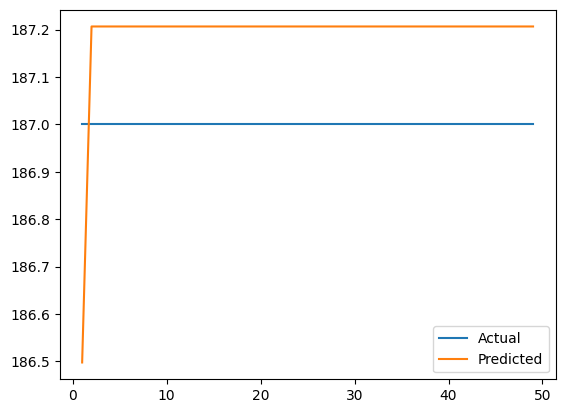

In [50]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [51]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,164.032364,162.0
1,163.435287,161.0
2,166.497253,163.0
3,168.086365,170.0
4,173.363312,178.0
...,...,...
310,66.403748,105.0
311,84.204643,134.0
312,130.115891,152.0
313,156.608398,139.0


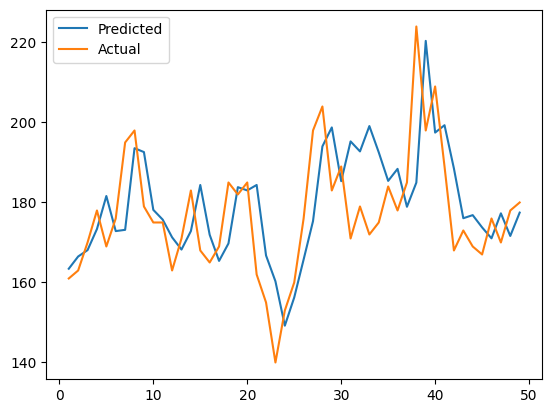

In [52]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

GRU

In [53]:
gru_model = Sequential()
gru_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
gru_model.add(BatchNormalization())
gru_model.add(Bidirectional(GRU(64, return_sequences=True)))
gru_model.add(Dropout(0.3))
gru_model.add(Bidirectional(GRU(32)))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(BatchNormalization())
gru_model.add(Dense(16, activation='relu'))
gru_model.add(Dense(1, activation='linear'))

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 6, 128)              │          27,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,141 (238.83 KB)

 Trainable params: 61,067 (238.54 KB)

 Non-trainable params: 74 (296.00 B)

In [54]:
cp2 = ModelCheckpoint('/kaggle/working/gru_model1.keras', save_best_only=True)

gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [55]:
gru_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp2])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 24207.6348 - mean_absolute_error: 146.4561 - val_loss: 19645.7578 - val_mean_absolute_error: 132.1068
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 23382.4004 - mean_absolute_error: 144.4196 - val_loss: 17426.9512 - val_mean_absolute_error: 125.2053
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21921.9902 - mean_absolute_error: 140.3363 - val_loss: 14855.5859 - val_mean_absolute_error: 116.2178
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20080.6660 - mean_absolute_error: 134.4060 - val_loss: 12545.4893 - val_mean_absolute_error: 107.1696
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18082.8086 - mean_absolute_error: 127.9295 - val_loss: 9968.8311 - val_mean_absolute_error: 95.9413
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15284.1758 - mean_absolute_error: 116.9291 - val_loss: 7617.5000 - val_mean_absolute_error: 84.0900
Epoch 7/100
80/80 ━━━━━━━━━━━━━━

In [56]:
from tensorflow.keras.models import load_model
model2 = load_model('/kaggle/working/gru_model1.keras')

In [57]:
# Evaluate the model on the train data
train_result = model2.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 14.3005
Mean Squared Error (MSE): 541.0272
Root Mean Squared Error (RMSE): 23.2600
R-squared (Accuracy): 0.8062


In [58]:
# Evaluate the model on the validation data
val_result = model2.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 11.0166
Mean Squared Error (MSE): 227.2821
Root Mean Squared Error (RMSE): 15.0759
R-squared (Accuracy): 0.9130


In [59]:
# Evaluate the model on the test data
test_result = model2.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 16.6472
Mean Squared Error (MSE): 483.6729
Root Mean Squared Error (RMSE): 21.9926
R-squared (Accuracy): 0.7576


In [60]:
train_predictions = model2.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,134.300827,153.0
1,132.915100,153.0
2,131.121780,153.0
3,143.869736,153.0
4,141.904312,153.0
...,...,...
2548,191.650085,207.0
2549,197.204697,198.0
2550,194.600662,193.0
2551,190.742279,163.0


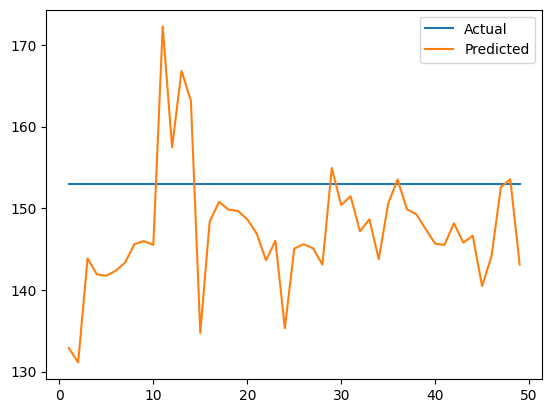

In [61]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [62]:
val_predictions = model2.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,180.423233,187.0
1,181.004379,187.0
2,181.761307,187.0
3,181.761307,187.0
4,181.761307,187.0
...,...,...
308,165.728699,178.0
309,169.328415,189.0
310,179.623978,173.0
311,172.704285,164.0


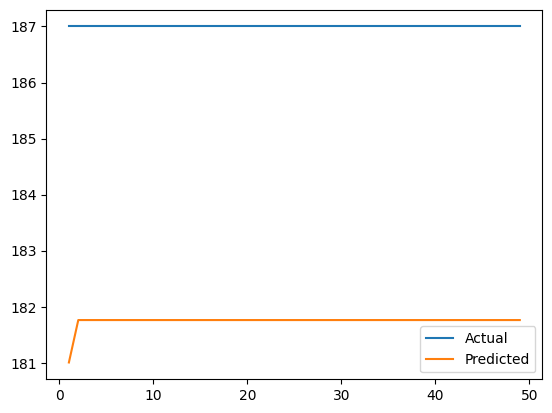

In [63]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [64]:
test_predictions = model2.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,154.934296,162.0
1,158.027710,161.0
2,159.394241,163.0
3,160.517242,170.0
4,168.110291,178.0
...,...,...
310,71.842232,105.0
311,89.309341,134.0
312,119.369003,152.0
313,141.546890,139.0


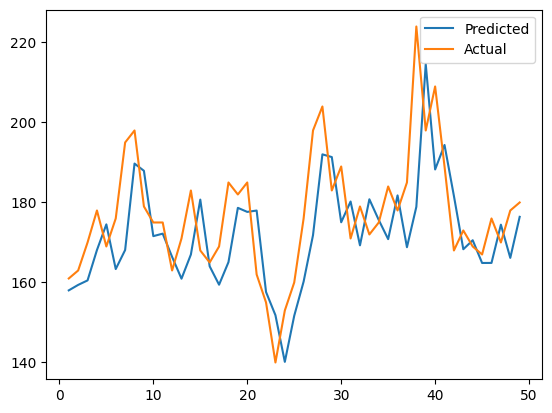

In [65]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

RNN

In [66]:
rnn_model = Sequential()
rnn_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
rnn_model.add(BatchNormalization())
rnn_model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
rnn_model.add(Dropout(0.3))
rnn_model.add(Bidirectional(SimpleRNN(32)))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(16, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))

rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_4                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 6, 128)              │           8,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,037 (86.08 KB)

 Trainable params: 21,963 (85.79 KB)

 Non-trainable params: 74 (296.00 B)

In [67]:
cp3 = ModelCheckpoint('/kaggle/working/rnn_model1.keras', save_best_only=True)

rnn_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [68]:
rnn_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp3])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 23657.6719 - mean_absolute_error: 145.2412 - val_loss: 19183.8770 - val_mean_absolute_error: 129.9447
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 22884.4805 - mean_absolute_error: 141.9845 - val_loss: 17330.8613 - val_mean_absolute_error: 124.1305
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22155.0371 - mean_absolute_error: 139.9355 - val_loss: 15490.4199 - val_mean_absolute_error: 117.6618
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20009.4707 - mean_absolute_error: 133.0051 - val_loss: 13200.9590 - val_mean_absolute_error: 108.8363
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17923.5977 - mean_absolute_error: 126.1734 - val_loss: 10648.2656 - val_mean_absolute_error: 97.9635
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14804.0635 - mean_absolute_error: 114.3800 - val_loss: 8376.9072 - val_mean_absolute_error: 86.6141
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━

In [69]:
from tensorflow.keras.models import load_model
model3 = load_model('/kaggle/working/rnn_model1.keras')

In [70]:
# Evaluate the model on the train data
train_result = model3.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 14.1089
Mean Squared Error (MSE): 581.5622
Root Mean Squared Error (RMSE): 24.1156
R-squared (Accuracy): 0.7917


In [71]:
# Evaluate the model on the validation data
val_result = model3.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 10.1907
Mean Squared Error (MSE): 229.2290
Root Mean Squared Error (RMSE): 15.1403
R-squared (Accuracy): 0.9122


In [72]:
# Evaluate the model on the test data
test_result = model3.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 17.5128
Mean Squared Error (MSE): 583.7286
Root Mean Squared Error (RMSE): 24.1605
R-squared (Accuracy): 0.7075


In [73]:
train_predictions = model3.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Train Predictions,Actuals
0,141.653915,153.0
1,143.053680,153.0
2,144.146317,153.0
3,142.724762,153.0
4,143.624313,153.0
...,...,...
2548,199.948776,207.0
2549,204.518768,198.0
2550,198.198822,193.0
2551,196.425980,163.0


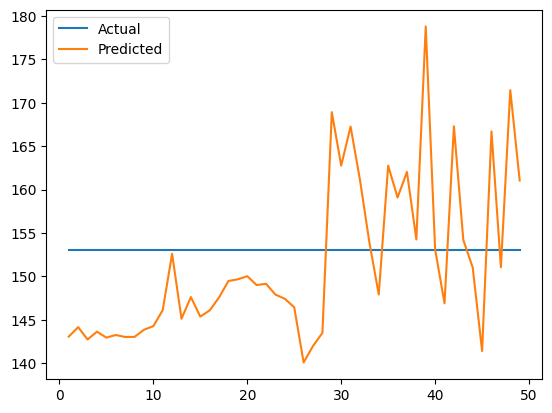

In [74]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [75]:
val_predictions = model3.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,186.417114,187.0
1,186.314835,187.0
2,188.845474,187.0
3,188.845474,187.0
4,188.845474,187.0
...,...,...
308,172.775482,178.0
309,175.628159,189.0
310,188.732346,173.0
311,176.860733,164.0


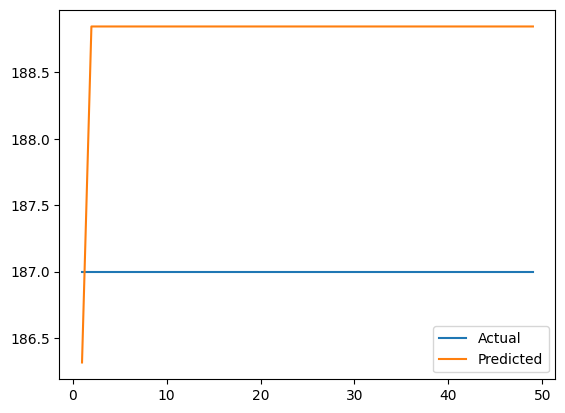

In [76]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [77]:
test_predictions = model3.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,157.464157,162.0
1,159.075577,161.0
2,166.727829,163.0
3,168.954437,170.0
4,164.716049,178.0
...,...,...
310,67.669861,105.0
311,95.953514,134.0
312,127.724922,152.0
313,143.718582,139.0


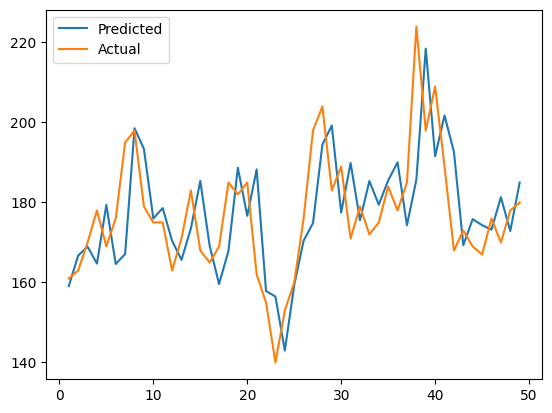

In [78]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

CNN-GRU(Bi)

In [79]:
cnn_gru_model = Sequential()
cnn_gru_model.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
cnn_gru_model.add(BatchNormalization())
cnn_gru_model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model.add(Dropout(0.3))
cnn_gru_model.add(Bidirectional(GRU(32, return_sequences=True)))
cnn_gru_model.add(Dropout(0.3))
cnn_gru_model.add(Bidirectional(GRU(16)))
cnn_gru_model.add(Dense(32, activation='relu'))
cnn_gru_model.add(BatchNormalization())
cnn_gru_model.add(Dense(16, activation='relu'))
cnn_gru_model.add(Dense(1, activation='linear'))

cnn_gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_6                │ (None, 6, 5)                │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 6, 128)              │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 6, 64)               │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 32)                  │           7,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,125 (215.33 KB)

 Trainable params: 55,051 (215.04 KB)

 Non-trainable params: 74 (296.00 B)

In [80]:
cp4 = ModelCheckpoint('/kaggle/working/cnn_gru_model1.keras', save_best_only=True)

cnn_gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [81]:
cnn_gru_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp4])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 23936.1738 - mean_absolute_error: 145.8841 - val_loss: 20671.0742 - val_mean_absolute_error: 135.3571
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23479.3672 - mean_absolute_error: 144.6690 - val_loss: 18857.3105 - val_mean_absolute_error: 129.8457
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21395.7754 - mean_absolute_error: 138.3312 - val_loss: 15955.3516 - val_mean_absolute_error: 120.0324
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19595.6680 - mean_absolute_error: 132.5546 - val_loss: 13622.4199 - val_mean_absolute_error: 111.6556
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17219.7539 - mean_absolute_error: 124.6741 - val_loss: 10597.0723 - val_mean_absolute_error: 99.0923
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 14345.6943 - mean_absolute_error: 114.1508 - val_loss: 8063.5137 - val_mean_absolute_error: 86.5919
Epoch 7/100
80/80 ━━━━━━━━━━━━━

In [82]:
from tensorflow.keras.models import load_model
model4 = load_model('/kaggle/working/cnn_gru_model1.keras')

In [83]:
# Evaluate the model on the train data
train_result = model4.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 14.4710
Mean Squared Error (MSE): 530.1366
Root Mean Squared Error (RMSE): 23.0247
R-squared (Accuracy): 0.8101


In [84]:
# Evaluate the model on the validation data
val_result = model4.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 10.6658
Mean Squared Error (MSE): 255.9512
Root Mean Squared Error (RMSE): 15.9985
R-squared (Accuracy): 0.9020


In [85]:
# Evaluate the model on the test data
test_result = model4.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 16.9578
Mean Squared Error (MSE): 517.7620
Root Mean Squared Error (RMSE): 22.7544
R-squared (Accuracy): 0.7405


In [86]:
train_predictions = model4.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,153.024841,153.0
1,154.307983,153.0
2,154.257050,153.0
3,152.158829,153.0
4,152.777191,153.0
...,...,...
2548,197.196655,207.0
2549,200.987778,198.0
2550,202.644379,193.0
2551,197.193207,163.0


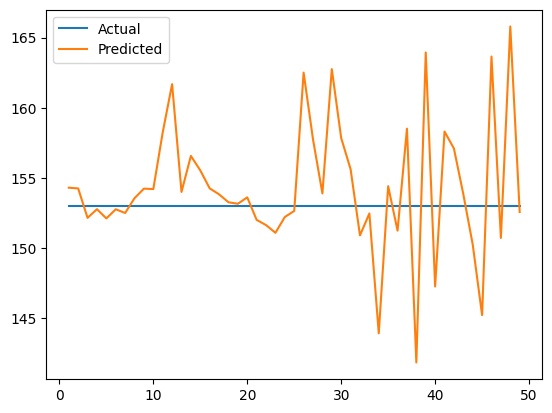

In [87]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [88]:
val_predictions = model4.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,185.442398,187.0
1,187.649017,187.0
2,188.174072,187.0
3,188.174072,187.0
4,188.174072,187.0
...,...,...
308,173.694214,178.0
309,174.755051,189.0
310,179.774933,173.0
311,173.461700,164.0


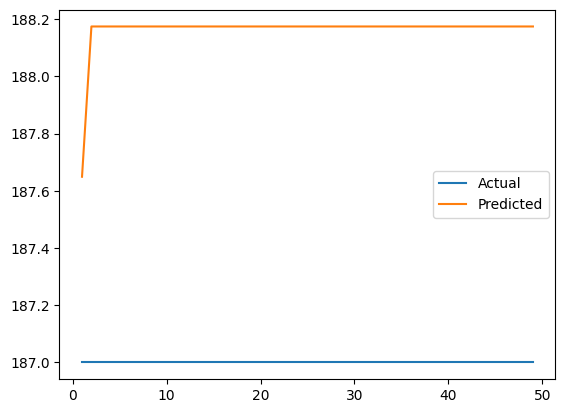

In [89]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [90]:
test_predictions = model4.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Train Predictions,Actuals
0,160.625671,162.0
1,159.531952,161.0
2,161.879028,163.0
3,161.350800,170.0
4,167.344864,178.0
...,...,...
310,73.059662,105.0
311,86.812874,134.0
312,107.460892,152.0
313,139.808990,139.0


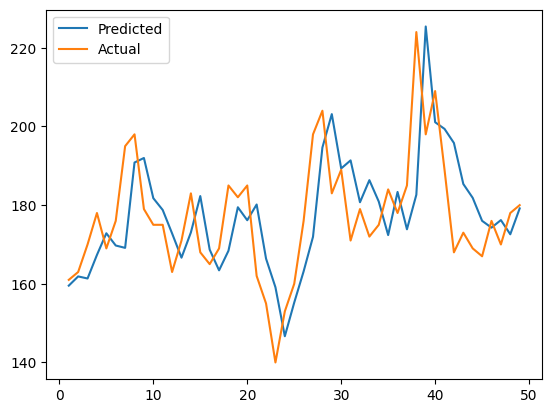

In [91]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

# 5 - Deep Learning Model(With Scaling)

# 5.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [ ]:
aqi_normal = new_data4.copy()

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aqi_normal)

In [ ]:
def new_data_to_X_y(new_data, window_size, train_pct, val_pct, test_pct):
    
    new_data_as_np = new_data
    
    # Split features and target
    features = new_data_as_np[:, :-1]  # All columns except the last one
    target = new_data_as_np[:, -1]     # Only the AQI column
    
    # Split data based on percentages
    total_len = len(features)
    train_end = int(train_pct * total_len)
    val_end = train_end + int(val_pct * total_len)
    
    # Prepare train, val, and test splits for both features and target
    train_features = features[:train_end]
    train_target = target[:train_end]
    
    val_features = features[train_end:val_end]
    val_target = target[train_end:val_end]
    
    test_features = features[val_end:]
    test_target = target[val_end:]
    
    # Helper function to create X and y
    def create_X_y(feature_data, target_data):
        X, y = [], []
        for i in range(len(feature_data) - window_size):
            # Create sequence of all features
            sequence = feature_data[i:i + window_size]
            X.append(sequence)
            # Get the target AQI value
            y.append(target_data[i + window_size])
        return np.array(X), np.array(y)
    
    
    X_train, y_train = create_X_y(train_features, train_target)
    X_val, y_val = create_X_y(val_features, val_target)
    X_test, y_test = create_X_y(test_features, test_target)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
WINDOW_SIZE = 6
NUM_FEATURES = 5
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = new_data_to_X_y(
    scaled_data, WINDOW_SIZE, train_pct, val_pct, test_pct
)

In [ ]:
# shapes
print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

#  5.2. DL Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

Bi-LSTM

In [ ]:
lstm_model_v = Sequential()
lstm_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
lstm_model_v.add(BatchNormalization())
lstm_model_v.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model_v.add(Dropout(0.3))
lstm_model_v.add(Bidirectional(LSTM(32)))
lstm_model_v.add(Dropout(0.3))
lstm_model_v.add(Dense(32, activation='relu'))
lstm_model_v.add(BatchNormalization())
lstm_model_v.add(Dense(16, activation='relu'))
lstm_model_v.add(Dense(1, activation='linear'))

lstm_model_v.summary()

In [ ]:
cp5 = ModelCheckpoint('/kaggle/working/lstm_model_v1.keras', save_best_only=True)

lstm_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [ ]:
lstm_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp5])

In [ ]:
from tensorflow.keras.models import load_model
model5 = load_model('/kaggle/working/lstm_model_v1.keras')

In [ ]:
# Evaluate the model on the train data
train_result = model5.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the validation data
val_result = model5.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the test data
test_result = model5.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
train_predictions = model5.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

In [ ]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
val_predictions = model5.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
test_predictions = model5.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

GRU

In [ ]:
gru_model_v = Sequential()
gru_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
gru_model_v.add(BatchNormalization())
gru_model_v.add(Bidirectional(GRU(64, return_sequences=True)))
gru_model_v.add(Dropout(0.3))
gru_model_v.add(Bidirectional(GRU(32)))
gru_model_v.add(Dropout(0.3))
gru_model_v.add(Dense(32, activation='relu'))
gru_model_v.add(BatchNormalization())
gru_model_v.add(Dense(16, activation='relu'))
gru_model_v.add(Dense(1, activation='linear'))

gru_model_v.summary()

In [ ]:
cp6 = ModelCheckpoint('/kaggle/working/gru_model_v1.keras', save_best_only=True)

gru_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [ ]:
gru_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp6])

In [ ]:
from tensorflow.keras.models import load_model
model6 = load_model('/kaggle/working/gru_model_v1.keras')

In [ ]:
# Evaluate the model on the train data
train_result = model6.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the validation data
val_result = model6.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the test data
test_result = model6.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
train_predictions = model6.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

In [ ]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
val_predictions = model6.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
test_predictions = model6.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

RNN

In [ ]:
rnn_model_v = Sequential()
rnn_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
rnn_model_v.add(BatchNormalization())
rnn_model_v.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
rnn_model_v.add(Dropout(0.3))
rnn_model_v.add(Bidirectional(SimpleRNN(32)))
rnn_model_v.add(Dropout(0.3))
rnn_model_v.add(Dense(32, activation='relu'))
rnn_model_v.add(BatchNormalization())
rnn_model_v.add(Dense(16, activation='relu'))
rnn_model_v.add(Dense(1, activation='linear'))

rnn_model_v.summary()

In [ ]:
cp7 = ModelCheckpoint('/kaggle/working/rnn_model_v1.keras', save_best_only=True)

rnn_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [ ]:
rnn_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp7])

In [ ]:
from tensorflow.keras.models import load_model
model7 = load_model('/kaggle/working/rnn_model_v1.keras')

In [ ]:
# Evaluate the model on the train data
train_result = model7.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the validation data
val_result = model7.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the test data
test_result = model7.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
train_predictions = model7.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

In [ ]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
val_predictions = model7.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
test_predictions = model7.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

CNN-GRU(Bi)

In [ ]:
cnn_gru_model_v = Sequential()
cnn_gru_model_v.add(InputLayer(shape=(WINDOW_SIZE, NUM_FEATURES)))
cnn_gru_model_v.add(BatchNormalization())
cnn_gru_model_v.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model_v.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_gru_model_v.add(Dropout(0.3))
cnn_gru_model_v.add(Bidirectional(GRU(32, return_sequences=True)))
cnn_gru_model_v.add(Dropout(0.3))
cnn_gru_model_v.add(Bidirectional(GRU(16)))
cnn_gru_model_v.add(Dense(32, activation='relu'))
cnn_gru_model_v.add(BatchNormalization())
cnn_gru_model_v.add(Dense(16, activation='relu'))
cnn_gru_model_v.add(Dense(1, activation='linear'))

cnn_gru_model_v.summary()

In [ ]:
cp8 = ModelCheckpoint('/kaggle/working/cnn_gru_model_v1.keras', save_best_only=True)

cnn_gru_model_v.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005), 
               metrics=[MeanAbsoluteError()])

In [ ]:
cnn_gru_model_v.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, 
           callbacks=[cp8])

In [ ]:
from tensorflow.keras.models import load_model
model8 = load_model('/kaggle/working/cnn_gru_model_v1.keras')

In [ ]:
# Evaluate the model on the train data
train_result = model8.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the validation data
val_result = model8.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
# Evaluate the model on the test data
test_result = model8.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

In [ ]:
train_predictions = model8.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

In [ ]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
val_predictions = model8.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [ ]:
test_predictions = model8.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

# Best model svr without scaling

In [92]:
from joblib import load  

# Load the model
model = load('/kaggle/working/models/best_model_svr_20250122_205635.joblib')

# Predict using the model
predictions = model.predict(data)

# Add predictions to the original dataframe
data['predictions'] = predictions 

os.makedirs('/kaggle/working', exist_ok=True)

# Save to CSV
data.to_csv('/kaggle/working/india_lucknow_predictions.csv')